In [1]:
from load_data import *
from helpers import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
tf.compat.v1.disable_v2_behavior()

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import shap

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Init Plugin
Init Graph Optimizer
Init Kernel
Instructions for updating:
non-resource variables are not supported in the long term


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Final prediction models
Use several different models with the selected features and compare their results in terms of R^2 and MSE

Models:
- Random Forest
- XGBoost
- Neural Network
- SVR (?)
- Linear Regression

## Data Preparation

In [2]:
# Load data
X_train, X_test, y_train, y_test = load_data()

model_score = []

Features got standardized.
Have fun implementing your models.


## Define R^2

In [3]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

In [4]:
def R_squared_adj(y, y_pred, k):
  r2 = R_squared(y, y_pred)
  n = len(y)
  r2_adj = 1.-((1.-r2)*(n-1.)/(n-k-1.))
  return r2

In [5]:
# from tensorflow.keras.metrics import Metric

# class R_sq_adj(Metric):
#     def __init__(self, k, name = "R2_adj"):
#         super(R_sq_adj, self).__init__(name = name)
#         self.k = tf.cast(k, dtype = tf.float32)
#         self.r2 = self.add_weight(name='r2', initializer='zeros')
#         self.n = self.add_weight(name='n', initializer='zeros')


#         ''' perform any calculations that don't rely on a specific y_true or y_pred
#         '''

#     def update_state(self, y_true, y_pred, sample_weight):
#         residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
#         total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
#         r2_tmp = tf.subtract(1.0, tf.math.divide(residual, total))
#         r2.assign
#         self.n.assign_add(len(y_true), dtype = tf.float32)
#         #self.r2_adj = tf.subtract(1,tf.multiply(tf.subtract(1.,r2), tf.divide(tf.subtract(n,1), tf.subtract(tf.subtract(self.k,1)))))
#         self.r2_adj.assign(1.-((1.-r2)*(self.n-1.)/(self.n-self.k-1.)))
    
#     def result(self):

#         return self.r2_adj
    
#     def reset_state(self):
#         self.r2.assign(0.)

In [6]:
# from tensorflow.keras.metrics import Metric

# class R_sq_adj(Metric):
#     def __init__(self, k, name = "R2_adj"):
#         super(R_sq_adj, self).__init__(name = name)
#         self.k = tf.cast(k, dtype = tf.float32)
#         self.n = tf.zeros([1], dtype = tf.float32)
#         self.y_true = tf.zeros([1,1], dtype = tf.float32)
#         self.y_pred = tf.zeros([1,1], dtype = tf.float32)
#         self.r2_adj = self.add_weight(name='r2', initializer='zeros', shape = (1,))


#         ''' perform any calculations that don't rely on a specific y_true or y_pred
#         '''

#     def update_state(self, y_true, y_pred, sample_weight):
#         self.n = self.n+tf.cast(len(y_true), dtype = tf.float32)
#         self.y_true = tf.squeeze(tf.concat([self.y_true, y_true], axis = 0))
#         self.y_pred = tf.squeeze(tf.concat([self.y_pred, y_pred], axis = 0))
#         print(self.y_true)
#         #self.r2_adj = tf.subtract(1,tf.multiply(tf.subtract(1.,r2), tf.divide(tf.subtract(n,1), tf.subtract(tf.subtract(self.k,1)))))
#         #self.r2_adj.assign(1.-((1.-r2)*(self.n-1.)/(self.n-self.k-1.)))
    
#     def result(self):
#         residual = tf.reduce_sum(tf.square(tf.subtract(self.y_true, self.y_pred)))
#         total = tf.reduce_sum(tf.square(tf.subtract(self.y_true, tf.reduce_mean(self.y_true))))
#         r2 = tf.subtract(1.0, tf.math.divide(residual, total))
#         self.r2_adj.assign(1.-((1.-r2)*(self.n-1.)/(self.n-self.k-1.)))
#         return self.r2_adj
    
#     def reset_state(self):
#         self.r2_adj.assign(0.)

## Random Forest

In [7]:
space={'max_depth': hp.quniform("max_depth", 2, 100, 2),
        "min_samples_split": hp.quniform("min_samples_split", 2, 1000, 2),
        "max_features": hp.quniform("max_features", 2,24,2),
        'n_estimators': 200,
        'seed': 0
    }
    
def objective(space):
    model = RandomForestRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']))
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:07<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
best_hyperparams
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])

In [81]:
# train a Random Forest
forest = RandomForestRegressor(n_estimators = 200, max_depth = int(best_hyperparams['max_depth'])).fit(X_train, y_train)

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [82]:
forest.score(X_test, y_test)

0.6472476816005108

In [83]:
y_pred = forest.predict(X_test)
R_squared(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.6472476816005109>

## XGBoost

In [ ]:
space={'max_depth': hp.quniform("max_depth", 2, 50, 2),
        'gamma': hp.uniform ('gamma', 0, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 50, 1),
        'n_estimators': 500,
        'seed': 0
    }
    
def objective(space):
    model=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    #evaluation = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(X_train, y_train)
    

    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [71]:
best_hyperparams
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


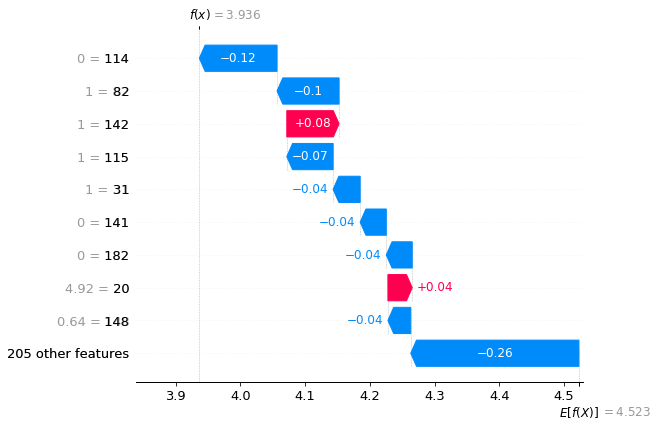

In [72]:
# train an XGBoost model
model = xgb.XGBRegressor(**best_hyperparams).fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[10])

In [73]:
model.score(X_test, y_test)

0.6747394474852844

In [72]:
y_pred = model.predict(X_test)
R_squared(y_test,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.658631170042137>

## Neural Network

Important parts:
- Regularization on the weights (L1 or L2)
- Dropout
- Layers (3 proposed in:
 @article{2021,
   title={Airbnb Price Prediction Using Machine Learning and Sentiment Analysis},
   ISBN={9783030840600},
   ISSN={1611-3349},
   url={http://dx.doi.org/10.1007/978-3-030-84060-0_11},
   DOI={10.1007/978-3-030-84060-0_11},
   journal={Machine Learning and Knowledge Extraction},
   publisher={Springer International Publishing},
   author={Rezazadeh Kalehbasti, Pouya and Nikolenko, Liubov and Rezaei, Hoormazd},
   year={2021},
   pages={173–184})

## TabNet

In [8]:
import tabnet


In [9]:
train_size = 6000
batch_size = 600

In [10]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

In [11]:
bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

In [12]:
data_train = tf.data.Dataset.from_tensor_slices({"features": X_train, "price": y_train})
data_train = data_train.shuffle(6000, seed = 13)
train_dataset = data_train.take(len(X_train))
train_dataset = train_dataset.map(transform)
train_dataset = train_dataset.batch(batch_size)

data_test = tf.data.Dataset.from_tensor_slices({"features": X_test, "price": y_test})
test_dataset = data_test.take(len(X_test))
test_dataset = test_dataset.map(transform)
test_dataset = test_dataset.batch(batch_size)

In [13]:
feature_columns = []

for col in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col))

In [14]:
model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=8,
                                num_decision_steps=3,num_groups = 1)

[TabNet]: 56 features will be used for decision steps.


In [15]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/TabNet',write_graph=False, write_images = True)
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.9, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='mse', metrics=[R_squared])


model.fit(train_dataset, epochs=10, validation_data=test_dataset, verbose=1, callbacks = [tb_callback])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-01-31 10:29:38.841347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-31 10:29:38.841472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-31 10:29:38.858230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-31 10:29:38.858517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 10:29:38.917122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 10:29:38.954424: I tensorflow/compiler/mlir/m

InvalidArgumentError: Node 'training/Adam/gradients/gradients/tab_net_regressor/tab_net/PartitionedCall_1_grad/PartitionedCall': Connecting to invalid output 1 of source node tab_net_regressor/tab_net/PartitionedCall_1 which has 1 outputs.

In [19]:
model.layers[0]

In [21]:
x, y = next(iter(train_dataset))
_ = model(x)

writer = tf.summary.create_file_writer("logs/TabNet")
with writer.as_default():
    for i, mask in enumerate(model.tabnet.feature_selection_masks):
        print("Saving mask {} of shape {}".format(i + 1, mask.shape))
        tf.summary.image('mask_at_iter_{}'.format(i + 1), step=0, data=mask, max_outputs=1)
        writer.flush()

    agg_mask = model.tabnet.aggregate_feature_selection_mask
    print("Saving aggregate mask of shape", agg_mask.shape)
    tf.summary.image("Aggregate Mask", step=0, data=agg_mask, max_outputs=1)
    writer.flush()

writer.close()

Saving mask 1 of shape (1, 600, 24, 1)
Saving mask 2 of shape (1, 600, 24, 1)
Saving aggregate mask of shape (1, 600, 24, 1)


2022-01-31 10:28:14.235885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [23]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [24]:

shap_values = shap.DeepExplainer(model, X_train)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[10])

TypeError: object of type 'NoneType' has no len()

In [27]:
model.outputs

TypeError: 'NoneType' object is not callable

## Support Vector Regression